# 媒体计算2022 小作业1 双边滤波
## 作业目标
实现对于图像的双边滤波。
## 滤波知识回顾
### 降噪与滤波
现实中的数字图像在数字化和传输过程中常受到成像设备与外部环境等影响，产生一定的噪声；通过光线追踪渲染出的图像在采样数不足的情况下也会具有较大的方差。所以，图像降噪对于提高图像的视觉质量具有重要的作用。而滤波是最常见的一类降噪方法，其核心思想为利用每个像素的邻域，减小像素的方差，通常做法为对每个像素和其周围像素进行加权平均或排序选择。滤波的具体算法有高斯滤波、中值滤波，双边滤波等等。接下来我们分别介绍一下高斯滤波和双边滤波。

### 一些定义
对于一张二维灰度图像$I$，我们定义：

$I(x_{ij})$为图像在第i行第j列处的亮度值，$x_{ij}$为二维的像素坐标

亮度和坐标的范围均归一化到[0,1]

距离的度量采用L2距离
### 高斯滤波
高斯滤波就是对一个像素$x_{ij}$周围的一定范围内的像素值分别赋以不同的权重值，并在加权平均后得到当前像素的最终结果。这个权重值符合高斯核函数：

$$\omega(x_{ij},x_{kl})=\frac{1}{2\pi\sigma_s^2}exp(-\frac{||x_{ij}-x_{kl}||^2}{2\sigma_s^2})$$

高斯核函数可视化的结果如下，可以看出，像素之间的距离越近，核函数的值越大，权重越大；距离越远，权重越小。

![al](gauss.png)

在实际应用中，我们采用的是离散的高斯滤波核函数，并且为节约计算量，我们通常只计算某个邻域范围内所有像素的权重，并进行加权平均：
$$I_{filtered}(x_{ij}) = \frac{\sum_{x_{kl}\in N(x_{ij})} I(x_{kl})\omega(x_{ij},x_{kl})}{\sum_{x_{kl}\in N(x_{ij})} \omega(x_{ij},x_{kl})}$$

对一幅图像应用高斯滤波之后的结果如下（原图与降噪结果）

![](lena.png)

![](lena_gauss.png)

可以看出在图像的平滑区域，高斯滤波能较好的去除图像中的噪声，可是在图像的边缘如帽子、眼睛的轮廓部分发生了模糊，因为高斯滤波把相邻的颜色差异较大的像素进行了平均。

为解决这个问题，我们引入双边滤波。

### 双边滤波
相比高斯滤波，bilateral filter双边滤波器可以在去噪的同时，很好的保留图像中的边缘信息，这是因为双边滤波在考虑图像的空间邻近度之外，还考虑了像素值相似度。

具体的来说，双边滤波的公式和高斯滤波基本一致，只不过权重$\omega(x_{ij},x_{kl})$分成了两部分的乘积：

$$\omega(x_{ij},x_{kl})=\frac{1}{2\pi\sigma_s^2}\frac{1}{2\pi\sigma_r^2}exp(-\frac{||x_{ij}-x_{kl}||^2}{2\sigma_s^2})exp(-\frac{||I(x_{ij})-I(x_{kl})||^2}{2\sigma_r^2})$$

乘积的第一部分和高斯滤波一样，衡量像素之间位置的相关性，而第二项衡量的是相邻像素的颜色相关性，颜色越接近，权重越大。

直观上理解，只有两个像素的颜色和位置都比较相近，权重才会比较大，这样，在图像边缘部分像素所在部分的另一侧的影响就会比较小，达到了保留边界的效果。

### 联合双边滤波

在渲染中，由于采样数不足导致渲染结果的方差较大，于是不在边界处的相邻像素颜色可能差异也比较大，此时应用双边滤波无法获得较好的降噪效果。但在渲染过程中，我们可以更轻松的获得一些方差较小的辅助信息如法线或深度信息，此时我们也可以应用这种辅助图像来判断相邻像素的值域相关性：

$$\omega(x_{ij},x_{kl})=\frac{1}{2\pi\sigma_s^2}\frac{1}{2\pi\sigma_r^2}exp(-\frac{||x_{ij}-x_{kl}||^2}{2\sigma_s^2})exp(-\frac{||A(x_{ij})-A(x_{kl})||^2}{2\sigma_r^2})$$

其中$A$代表的就是辅助图像。


## 算法实现
首先，引入一些python库，并读取图片

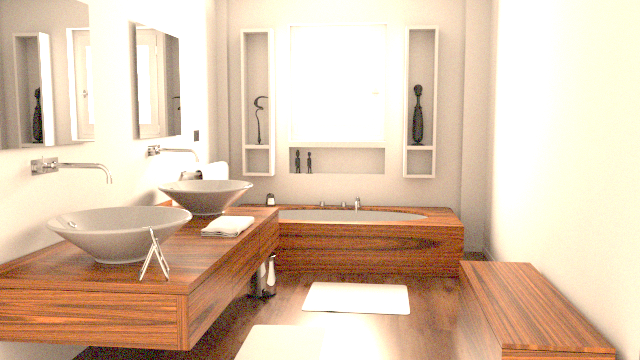

In [1]:
import numpy as np
from PIL import Image
from tqdm import tqdm #进度条
import sys
import math
src = np.asarray(Image.open("noise.png"))[...,:3]
display(Image.fromarray(src))
src_norm = src/255.0

接下来分别对每个像素进行三种滤波操作。

将每个像素的邻域设置为以该像素为中心，边长为filter_diameter的正方形，邻域像素权重按照上述公式计算。

对于联合双边滤波，提供辅助的法线图像。

请同学参照提供代码，补充三种滤波代码。

### 高斯滤波

100%|██████████| 360/360 [00:21<00:00, 16.84it/s]


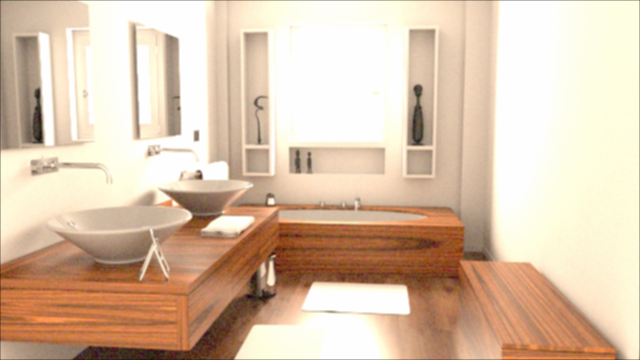

In [4]:

def gaussian_filter(source, x, y, diameter, sigma_s):
    #source: noisy input image
    #x,y: pixel coordinate
    #diameter: 邻域设置为以x,y为中心，diameter为边长的正方形，邻域中超出边界的像素不参与计算
    #sigma_s: 参照高斯滤波公式

    filtered = np.zeros(3)
    #need your code here
    ax = np.linspace(-(diameter - 1) / 2., (diameter - 1) / 2., diameter)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma_s))
    kernel=kernel/np.sum(kernel)
    half_d = diameter // 2
    for dx in range(-half_d, half_d + 1):
        for dy in range(-half_d, half_d + 1):
            if 0 <= x + dx < source.shape[0] and 0 <= y + dy < source.shape[1]:
                weight = kernel[dx + half_d, dy + half_d]
                filtered += weight * source[x + dx, y + dy]
    return filtered

filter_diameter=3
sigma_s = 1 #0.2
gaussian_filtered_image = np.zeros(src_norm.shape)
bilateral_filtered_image = np.zeros(src_norm.shape)
joint_bilateral_filtered_image = np.zeros(src_norm.shape)

for i in tqdm(range(src_norm.shape[0])):
    for j in range(src_norm.shape[1]):
        gaussian_filtered_image[i][j] = gaussian_filter(src_norm, i, j, filter_diameter, sigma_s)

display(Image.fromarray((gaussian_filtered_image*255).astype(np.uint8)))
Image.fromarray((gaussian_filtered_image*255).astype(np.uint8)).save("result_gf.png")


### 双边滤波

100%|██████████| 360/360 [01:08<00:00,  5.25it/s]


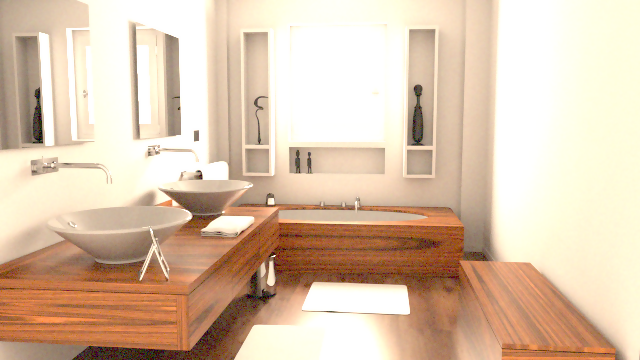

In [5]:
def bilateral_filter(source, x, y, diameter, sigma_r, sigma_s):
    #source: noisy input image
    #x,y: pixel coordinate
    #diameter: 邻域设置为以x,y为中心，diameter为边长的正方形，邻域中超出边界的像素不参与计算
    #sigma_r/sigma_s: 参照双边滤波公式
    
    filtered = np.zeros(3)
    #need your code here
    ax = np.linspace(-(diameter - 1) / 2., (diameter - 1) / 2., diameter)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma_s))
    kernel=kernel/np.sum(kernel)
    half_d = diameter // 2

    filtered = np.zeros(3)  
    norm_factor = 0  
    for dx in range(-half_d, half_d + 1):
        for dy in range(-half_d, half_d + 1):
            if 0 <= x + dx < source.shape[0] and 0 <= y + dy < source.shape[1]:
                neighbor_intensity = source[x + dx, y + dy]
                center_intensity = source[x, y]

                spatial_weight = kernel[dx + half_d, dy + half_d]
                range_weight = np.exp(-0.5 * np.linalg.norm(neighbor_intensity - center_intensity) ** 2 / sigma_r ** 2)
                weight = spatial_weight * range_weight

                filtered += weight * neighbor_intensity
                norm_factor += weight

    return filtered / norm_factor if norm_factor > 0 else source[x, y]



#you can try different parameters here(optional)
filter_diameter=5       #1
sigma_r = 0.1         #0.1
sigma_s = 1       #0.1
bilateral_filtered_image = np.zeros(src_norm.shape)

for i in tqdm(range(src_norm.shape[0])):
    for j in range(src_norm.shape[1]):
        bilateral_filtered_image[i][j] = bilateral_filter(src_norm, i, j, filter_diameter, sigma_r, sigma_s)

display(Image.fromarray((bilateral_filtered_image*255).astype(np.uint8)))
Image.fromarray((bilateral_filtered_image*255).astype(np.uint8)).save("result_bf.png")

### 联合双边滤波

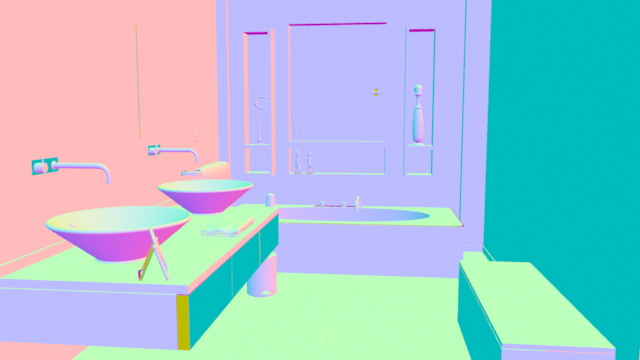

  0%|          | 0/360 [00:00<?, ?it/s]

100%|██████████| 360/360 [01:11<00:00,  5.07it/s]


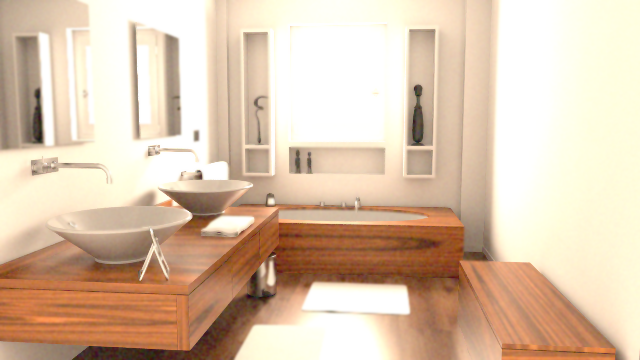

In [6]:
def joint_bilateral_filter(source, aux, x, y, diameter, sigma_r, sigma_s):
    #source: noisy input image
    #aux: auxiliary image
    #x,y: pixel coordinate
    #diameter: 邻域设置为以x,y为中心，diameter为边长的正方形，邻域中超出边界的像素不参与计算
    #sigma_r/sigma_s: 参照双边滤波公式
    
    filtered = np.zeros(3)
    #need your code here
    ax = np.linspace(-(diameter - 1) / 2., (diameter - 1) / 2., diameter)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma_s))
    kernel=kernel/np.sum(kernel)
    half_d = diameter // 2

    filtered = np.zeros(3)  # Assuming a 3-channel (RGB) image
    norm_factor = 0  # Normalization factor

    for dx in range(-half_d, half_d + 1):
        for dy in range(-half_d, half_d + 1):
            # Check if the pixel is inside the image boundaries
            if 0 <= x + dx < source.shape[0] and 0 <= y + dy < source.shape[1]:
                neighbor_intensity_source = source[x + dx, y + dy]
                neighbor_intensity_aux = aux[x + dx, y + dy]
                center_intensity_aux = aux[x, y]

                spatial_weight = kernel[dx + half_d, dy + half_d]
                range_weight = np.exp(-0.5 * np.linalg.norm(neighbor_intensity_aux - center_intensity_aux) ** 2 / sigma_r ** 2)
                
                weight = spatial_weight * range_weight

                filtered += weight * neighbor_intensity_source
                norm_factor += weight

    return filtered / norm_factor if norm_factor > 0 else source[x, y]



aux = np.asarray(Image.open("normal.png"))
display(Image.fromarray(aux))
aux_norm = aux/255.0

#you can try different parameters here(optional)
filter_diameter=5
sigma_r = 0.1       #0.1
sigma_s = 1         #0.1
joint_bilateral_filtered_image = np.zeros(src_norm.shape)

for i in tqdm(range(src_norm.shape[0])):
    for j in range(src_norm.shape[1]):
        joint_bilateral_filtered_image[i][j] = joint_bilateral_filter(src_norm, aux_norm, i, j, filter_diameter, sigma_r, sigma_s)

display(Image.fromarray((joint_bilateral_filtered_image*255).astype(np.uint8)))
Image.fromarray((joint_bilateral_filtered_image*255).astype(np.uint8)).save("result_jbf.png")

## 评分

降噪结果合理，能体现出不同方法的区别即可获得满分。

最终提交一个压缩文件，包含填充代码后的本文件和三种方法的降噪结果。